# EDA and Cleaning

In the last notebook I have collected the data in this I will explolre the data and clean it.

---

In [150]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

## Functions

In [151]:
def count_most_common_words(df, column_to_vectirize, n_most_common, ngram_range=(1,1)):
    '''
    Takes:
    Data Frame
    Column that needs to be vectorized
    Number of most common words to return
    Ngram_range Tuple "The lower and upper boundary of the range of n-values for different word n-grams" default (1,1)
    
    Outputs:
    Data Frame with N most common words
    
    '''
    cvec = CountVectorizer(ngram_range=ngram_range, stop_words = 'english')
    cvec.fit(df[column_to_vectirize])
    vectorized_column = cvec.transform(df[column_to_vectirize])
    vectorized_df = pd.DataFrame(vectorized_column.todense(), columns = cvec.get_feature_names_out())
    return vectorized_df.sum().sort_values(ascending = False).head(n_most_common)

In [152]:
def remove_words(df, column, list_of_words):
    '''
    Function to remove words from column in the Data Frame
    Input:
    Data Frame
    Column from wich to remove words
    List of words to remove
    
    Outputs Data Frame with words removed from column
    '''
    for word in list_of_words:
        df[column] = df[column].str.replace(word, '')
    return df

---

In [153]:
# Get the data
reddit = pd.read_csv('../data/reddit.csv')

In [154]:
reddit.head()

,subreddit,selftext,title,created_utc
0,bioinformatics,This question has been dealt with before in th...,Differences between genome builds,1673302734
1,bioinformatics,"&amp;#x200B;\n\nCurious, anyone in need of a c...",Anyone need a solid Rust developer familiar wi...,1673291931
2,bioinformatics,NaN,We're wasting money by only supporting gzip fo...,1673287206
3,bioinformatics,I want to quickly check whether a particular g...,Any publicly available mapped human WGS datase...,1673284236
4,bioinformatics,I am currently working on the Gut microbiome a...,Pipeline for Gene Sequencing,1673280166


In [155]:
# Selftext is a bit obscure name, I want to change it to be more explicit 
reddit.rename(columns = {'selftext': 'post_body_text'}, inplace = True)
reddit.head()

,subreddit,post_body_text,title,created_utc
0,bioinformatics,This question has been dealt with before in th...,Differences between genome builds,1673302734
1,bioinformatics,"&amp;#x200B;\n\nCurious, anyone in need of a c...",Anyone need a solid Rust developer familiar wi...,1673291931
2,bioinformatics,NaN,We're wasting money by only supporting gzip fo...,1673287206
3,bioinformatics,I want to quickly check whether a particular g...,Any publicly available mapped human WGS datase...,1673284236
4,bioinformatics,I am currently working on the Gut microbiome a...,Pipeline for Gene Sequencing,1673280166


In [156]:
# Check for missing data
reddit.isnull().sum()

subreddit           0
post_body_text    399
title               0
created_utc         0
dtype: int64

In my subreddits the text of the post is missing in some cases, I will model on the title first and then add text and see if F1 score will improve. The created_utc was used for collecting the data and I do not need it for modeling

In [157]:
reddit.drop(columns = 'created_utc', inplace = True)

In [158]:
# Find the base line
reddit['subreddit'].value_counts(normalize=True)

datascience       0.672108
bioinformatics    0.327892
Name: subreddit, dtype: float64

My baseline is 67%

In [159]:
# Change titles to lower case
reddit['title'] = reddit['title'].str.lower()
reddit['post_body_text'] = reddit['post_body_text'].str.lower()

In [160]:
# Change the subreddit names to numbers for modeling
reddit['subreddit_num'] = reddit['subreddit'].map({'bioinformatics': 1, 'datascience ': 0})
reddit.head()

,subreddit,post_body_text,title,subreddit_num
0,bioinformatics,this question has been dealt with before in th...,differences between genome builds,1.0
1,bioinformatics,"&amp;#x200b;\n\ncurious, anyone in need of a c...",anyone need a solid rust developer familiar wi...,1.0
2,bioinformatics,NaN,we're wasting money by only supporting gzip fo...,1.0
3,bioinformatics,i want to quickly check whether a particular g...,any publicly available mapped human wgs datase...,1.0
4,bioinformatics,i am currently working on the gut microbiome a...,pipeline for gene sequencing,1.0


In [161]:
# Save data to file before exploring
reddit.to_csv('../data/reddit_cleaned.csv', index=False)

In [115]:
# Check the difference between title and self_text length for Bioinformatics and Data Science
reddit['title_length'] = reddit['title'].map(lambda x: len(x))
reddit['post_body_text_length'] = reddit['post_body_text'].map(lambda x: len(str(x)))
reddit.groupby('subreddit')[['title_length', 'post_body_text_length']].mean()

,title_length,post_body_text_length
subreddit,,
bioinformatics,58.361640,551.986823
datascience,59.399286,473.395714


The average Title length is about the same for Bioinformatics and Data Science, however, the average length of the body of the post is different, higher for bioinformatics.
I want to check if most of the missing texts are from Data Science.

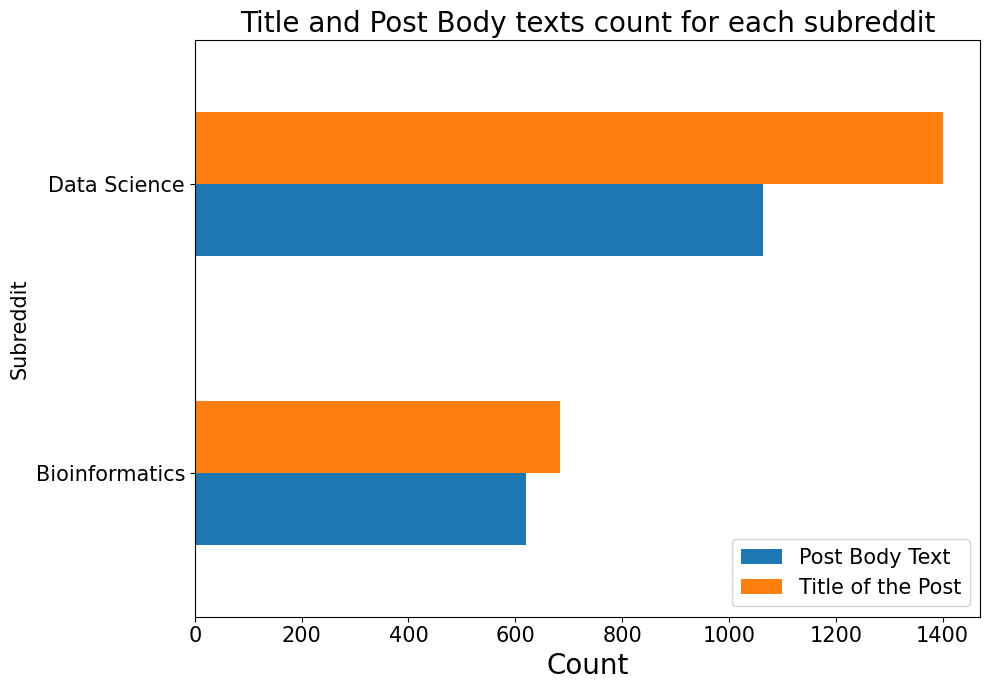

In [116]:
reddit.groupby('subreddit')[['post_body_text', 'title']].count().plot(kind='barh', figsize=(10, 7));
plt.title('Title and Post Body texts count for each subreddit', size = 20)
plt.xticks(size = 15)
plt.xlabel('Count', size = 20)
plt.yticks(np.arange(2), ['Bioinformatics', 'Data Science'], size = 15)
plt.ylabel('Subreddit', size = 15)
plt.legend(fontsize = 15, labels = ['Post Body Text', 'Title of the Post'])
plt.tight_layout()
plt.savefig('../images/title_post_body_counts.jpeg');

As I suspected Data Science has much more missing post body texts than Bioinformatics, it can influence the average length of the post.

In [117]:
# Check the difference between title word count for Bioinformatics and Data Science 
reddit['title_word_count'] = reddit['title'].map(lambda x: len(x.split()))
reddit.groupby('subreddit')['title_word_count'].mean()

subreddit
bioinformatics     9.229868
datascience       10.011429
Name: title_word_count, dtype: float64

The difference between average count of words per title is small.

---

### Title Most Common Words

In [119]:
# Most Common words in Data Science Subreddit
datascience_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'title', 10)
datascience_title_most_common

data         646
science      331
resume        77
ds            70
learning      66
job           63
best          60
analytics     60
scientist     59
python        54
dtype: int64

In [120]:
# Most Common words in Bioinformatics Subreddit
bioinformatics_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'title', 10)
bioinformatics_title_most_common

bioinformatics    110
data               52
help               46
gene               36
analysis           32
seq                25
using              24
phd                23
cell               22
genome             21
dtype: int64

Data and Science are by far the most common words in Data Science Subreddit. I can see that data in it is used not only together with Science, however it is too prevalent still to use. In Biostatistics the most common word by far is bioinformatics. I will need to remove the names of subreddits from the features to train model to recognize subreddits without this easy clue. 

In [122]:
# Drop data, science, ds and bioinformatics from reddit data
words_to_delete = ['bioinformatics', 'data', 'science', 'ds']

reddit = remove_words(reddit, 'title', words_to_delete)

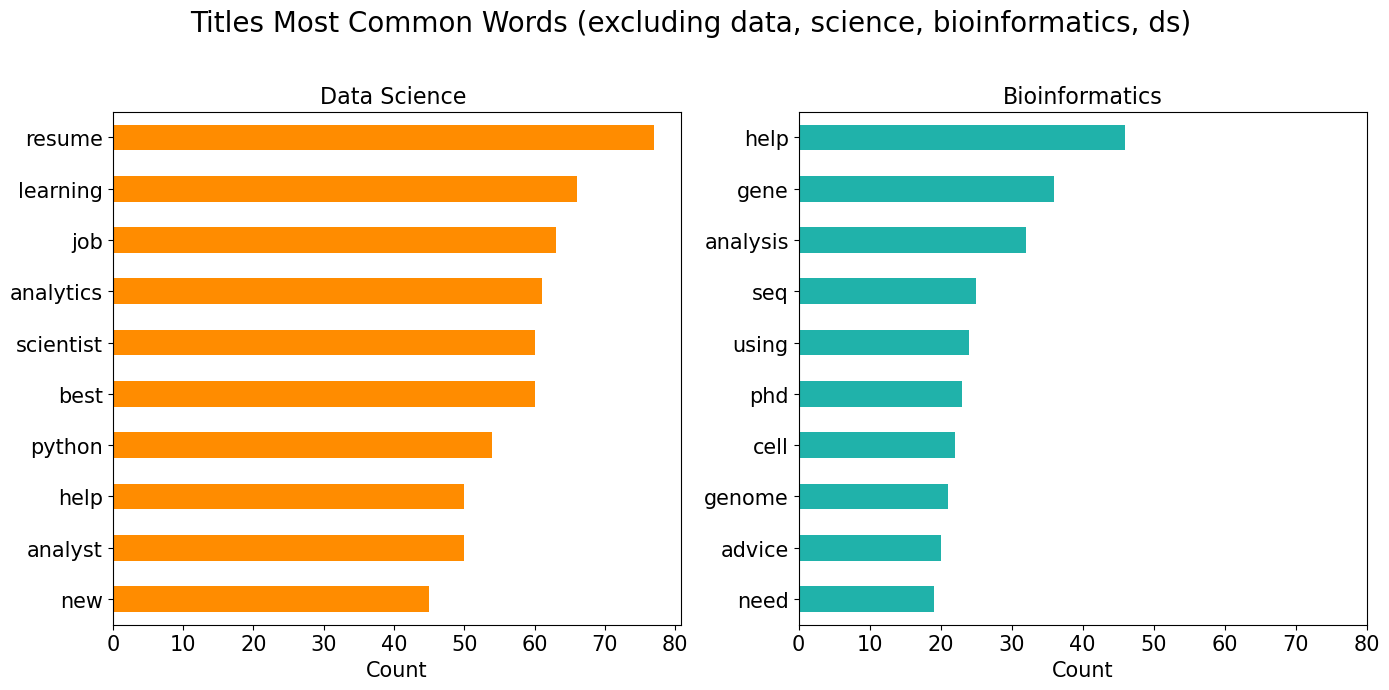

In [131]:
# adapted from breakfast hour and https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller

# Set figure
fig, ax = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('Titles Most Common Words (excluding data, science, bioinformatics, ds) \n', fontsize=20)

# Plot Data Science most common words
datascience_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'title', 10)
datascience_title_most_common.plot(kind = 'barh', color = 'darkorange', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Data Science ', fontsize=16)
ax[0].set_xlabel('Count', fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

# Plot Bioinformatics most common words
bioinformatics_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'title', 10)
bioinformatics_title_most_common.plot(kind = 'barh', color = 'lightseagreen', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Bioinformatics', fontsize=16)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlim([0, 80])

# Save for the presintation 
plt.tight_layout()
plt.savefig('../images/title_most_common_words.jpeg');

The only overlap that can be see here is help. Also, there are several similar words - analytics, analyst and analysis.

---

### Post Body Most Common Words 

In [124]:
# To find most common words in Post Body Text I will impute all rows with missing data with 'missing'
reddit_no_missing = reddit.fillna('missing').copy()
datascience_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'post_body_text', 10)
datascience_post_body_text_most_common

data       1733
science     606
like        495
work        373
https       362
amp         355
missing     350
job         324
know        312
just        301
dtype: int64

Missing shows even here on Data Science 10 most commont words

In [125]:
bioinformatics_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'post_body_text', 10)
bioinformatics_post_body_text_most_common

bioinformatics    328
data              313
like              260
amp               254
know              174
using             169
work              165
https             160
ve                154
use               152
dtype: int64

In [126]:
# Drop data, science, ds and bioinformatics from reddit data
words_to_delete = ['bioinformatics', 'data', 'science', 'missing']

reddit = remove_words(reddit_no_missing, 'post_body_text', words_to_delete)

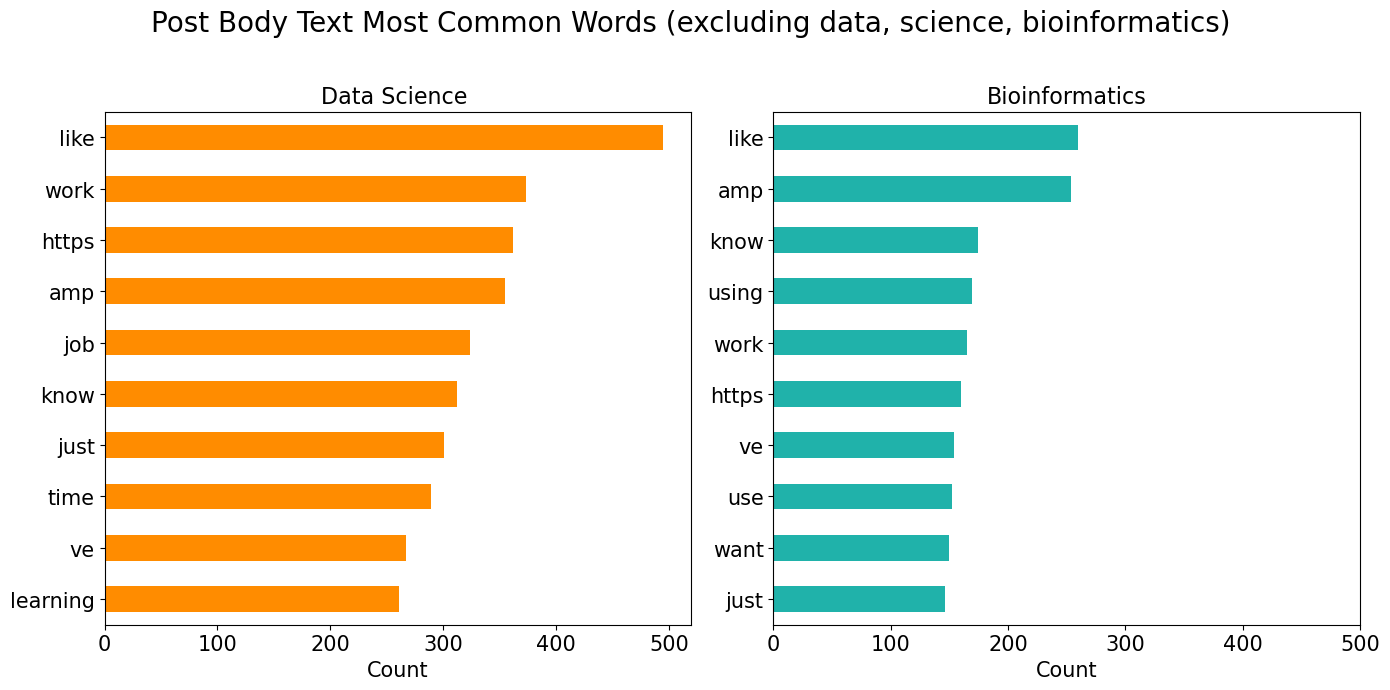

In [133]:
# Set figure
fig, ax = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('Post Body Text Most Common Words (excluding data, science, bioinformatics) \n', fontsize=20)

# Plot Data Science most common words
datascience_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'post_body_text', 10)
datascience_post_body_text_most_common.plot(kind = 'barh', color = 'darkorange', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Data Science ', fontsize=16)
ax[0].set_xlabel('Count', fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

# Plot Bioinformatics most common words
bioinformatics_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'post_body_text', 10)
bioinformatics_post_body_text_most_common.plot(kind = 'barh', color = 'lightseagreen', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Bioinformatics', fontsize=16)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlim([0, 500])

# Save for the presintation 
plt.tight_layout()
plt.savefig('../images/post_body_most_common_words.jpeg');

Post Body Text most common word is the same for both subreddits - like. Seven out of ten most common words are the same. Most likely adding post body text will not improve the model perfomance

---

### Most Common Bigrams 

In [136]:
# Most Common bigrams in Data Science Subreddit
datascience_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'datascience'], 'post_body_text', 10, (2,2))
datascience_title_most_common

https www           135
amp x200b           135
machine learning    105
don know             64
auto webp            41
amp format           41
reddit com           41
webp amp             41
preview redd         41
amp auto             41
dtype: int64

In [137]:
# Most Common bigrams in Bioinformatics Subreddit
bioinformatics_title_most_common = count_most_common_words(reddit[reddit['subreddit'] == 'bioinformatics'], 'post_body_text', 10, (2,2))
bioinformatics_title_most_common

fq gz            112
amp x200b         87
_r1 fq            57
_r2 fq            56
https www         45
rna seq           36
wet lab           35
feel like         33
https preview     31
webp amp          31
dtype: int64

For Post Body Text almost all most common bigrams are parts of the links.

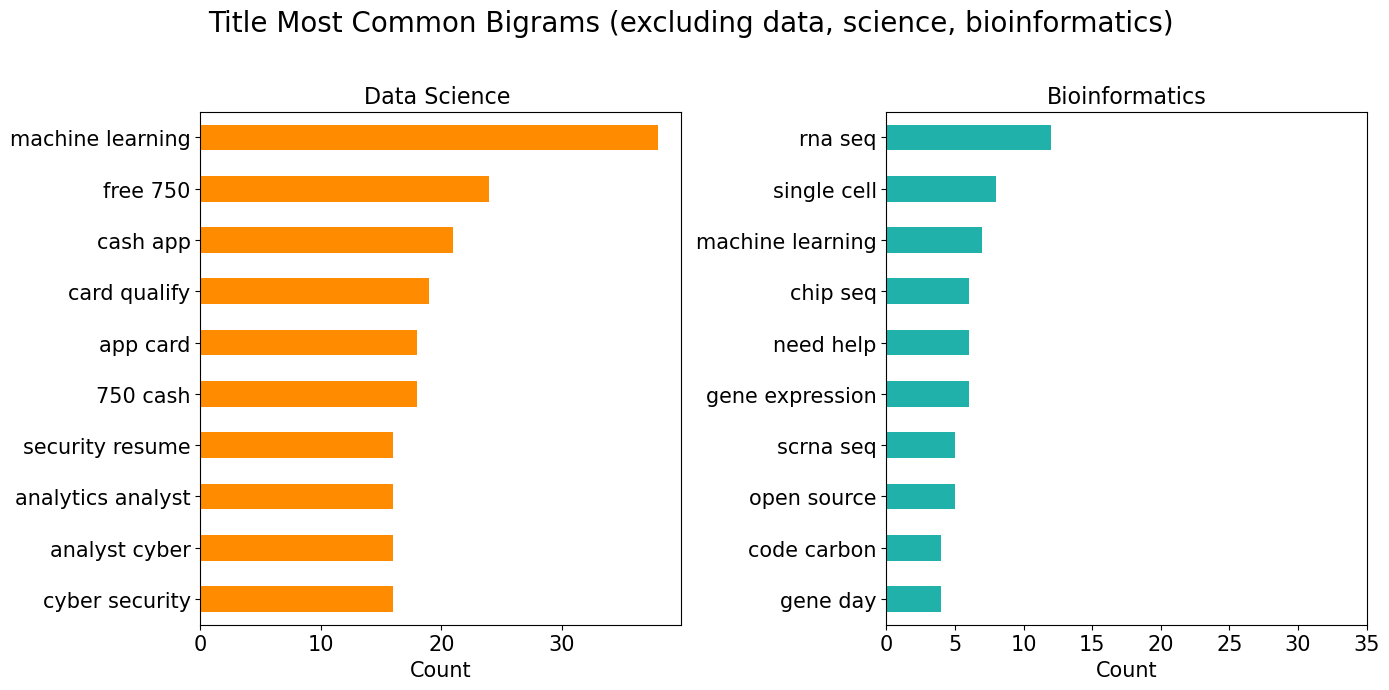

In [145]:
# Set figure
fig, ax = plt.subplots(1,2, figsize=(14,7))
fig.suptitle('Title Most Common Bigrams (excluding data, science, bioinformatics) \n', fontsize=20)

# Plot Data Science most common words
datascience_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'datascience'], 'title', 10, (2,2))
datascience_post_body_text_most_common.plot(kind = 'barh', color = 'darkorange', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Data Science ', fontsize=16)
ax[0].set_xlabel('Count', fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)

# Plot Bioinformatics most common words
bioinformatics_post_body_text_most_common = count_most_common_words(reddit_no_missing[reddit_no_missing['subreddit'] == 'bioinformatics'], 'title', 10, (2,2))
bioinformatics_post_body_text_most_common.plot(kind = 'barh', color = 'lightseagreen', ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('Bioinformatics', fontsize=16)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[1].set_xlim([0, 35])

# Save for the presintation 
plt.tight_layout()
plt.savefig('../images/title_common_bigrams.jpeg');

For Bioinformatics the bigrams are scarce, even in top ten the last one has less than 5 repetition. I will not use bigrams for modelling

In [162]:
# Save data with removed words to the file
reddit.to_csv('../data/reddit_cleaned_removed_words.csv', index=False)

---

In this notebook I have cleaned and explored the data.
The Post Body Text of Data Science subreddit has substantial amount of missing data and the most common words are similar between subreddits. The bigrams contain almost only parts of the links. I will not depend on the body for modeling. Probably, it will not help.
I will model on Title. It has different top 10 words for Data Science and Bioinformatics.
Bigrams did not show any miningful data, I will not use them for modeling.
I have saved to files, as I want to try TfidfVectorizer to combat the abandance of the Subreddit names in the texts.
In the next notebook I will build first model.